# Parking Lot Occupancy Estimation - YOLOv8 Training

**Authors:** Aminu Yiwere, Olatunji Olagundoye  
**Date:** November 14, 2025  
**Model:** YOLOv8 Object Detection

---


## 1. Setup and Installation


In [1]:

# Install required packages
%pip install -q ultralytics opencv-python matplotlib pyyaml


Note: you may need to restart the kernel to use updated packages.


In [2]:

# Import libraries
import os
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from ultralytics import YOLO

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.9.0
CUDA available: False


## 2. Dataset Configuration

Set `DATASET_ROOT` to the folder that contains `train/`, `valid/`, and `test` (for example, a Drive path in Colab). The notebook falls back to `../Dataset-V1-detect` or `../Dataset-V1` when running locally.


In [9]:

# Dataset path resolution (prefers the detection-ready labels)
from pathlib import Path as _Path

candidate_paths = []
if os.getenv('DATASET_ROOT'):
    candidate_paths.append(_Path(os.getenv('DATASET_ROOT')).expanduser())

candidate_paths.extend([
    Path('/Users/ay/Desktop/deeplearning/Parking lot /Dataset-V1-detect'),
    Path('/Users/ay/Desktop/deeplearning/Parking lot /Parking-Lot-Occupancy-Estimation-/Dataset-V1-detect'),
])

dataset_path = None
for path in candidate_paths:
    if path and path.exists():
        dataset_path = path.resolve()
        break

if dataset_path is None:
    raise FileNotFoundError(
        "Dataset not found. Set DATASET_ROOT to the directory containing train/valid/test (e.g., /content/drive/MyDrive/Datasets/Dataset-V1-detect)."
    )

data_yaml = dataset_path / 'data.yaml'

print("📂 Dataset Verification")
print('=' * 60)
print(f"Dataset path: {dataset_path}")
print(f"Exists: {dataset_path.exists()}")
print(f"data.yaml exists: {data_yaml.exists()}")

image_exts = {'.jpg', '.jpeg', '.png', '.bmp'}

def count_files(directory: Path, extensions) -> int:
    if not directory.exists():
        return 0
    return sum(1 for f in directory.iterdir() if f.suffix.lower() in extensions)

if dataset_path.exists():
    print("\nDataset structure:")
    for split in ['train', 'valid', 'test']:
        split_path = dataset_path / split
        images_path = split_path / 'images'
        labels_path = split_path / 'labels'
        num_images = count_files(images_path, image_exts)
        num_labels = count_files(labels_path, {'.txt'})
        print(f"  {split}/: {num_images} images, {num_labels} labels")

if data_yaml.exists():
    print("\n📄 data.yaml contents:")
    with open(data_yaml, 'r') as f:
        data_config = yaml.safe_load(f)
    print(yaml.dump(data_config, default_flow_style=False))
else:
    raise FileNotFoundError('data.yaml not found in the dataset directory.')


📂 Dataset Verification
Dataset path: /Users/ay/Desktop/deeplearning/Parking lot /Parking-Lot-Occupancy-Estimation-/Dataset-V1-detect
Exists: True
data.yaml exists: True

Dataset structure:
  train/: 345 images, 345 labels
  valid/: 38 images, 38 labels
  test/: 18 images, 18 labels

📄 data.yaml contents:
names:
- car
- lot_boundary
- objects
- stall
nc: 4
path: .
test: test/images
train: train/images
val: valid/images



## 3. Visualize Annotations

Improved visualization that handles large boxes and thin lines properly.


Showing ALL classes to verify Dataset-V1-detect has proper bboxes

🎨 Visualizing 6 samples from train set
📂 Dataset: Dataset-V1-detect

Sample 1: surrey_west_r0_c0_z20_614x614-2x_png.rf.9c0815ac4d4b407e8df99f0744f2a559.jpg
  ✓ car: 8
  ✓ lot_boundary: 1
Sample 2: Burnaby_r0_c2_z20_614x614-2x_png.rf.058f66bb005dd2a2c20a59a67c0b502b.jpg
  ✓ lot_boundary: 1
  ✓ stall: 49
  ✓ car: 43
  ✓ objects: 3
Sample 3: Abbotsford_East_r2_c1_z20_614x614-2x_png.rf.5b2f6ce008cd3972e6df60bb291350db.jpg
  ✓ lot_boundary: 1
  ✓ stall: 134
  ✓ objects: 6
  ✓ car: 89
Sample 4: N_Vancouver_r1_c1_z20_614x614-2x_png.rf.db49faae41de3fbbf6fc00a52864e538.jpg
  ✓ lot_boundary: 1
  ✓ stall: 92
  ✓ objects: 7
  ✓ car: 57
Sample 5: Maple_Ridge_r2_c1_z20_614x614-2x_png.rf.7256ddd1e2b6dba0eef0ad0a1a8a2b96.jpg
  ✓ lot_boundary: 1
  ✓ objects: 5
  ✓ stall: 41
  ✓ car: 34
Sample 6: Langley_66th_ave_r2_c2_z20_614x614-2x_png.rf.56cacbf59aa9cc74c7cf4da64bd2f406.jpg
  ✓ car: 5
  ✓ lot_boundary: 1
Sample 5: Maple_Ridge_r2_c1_z2

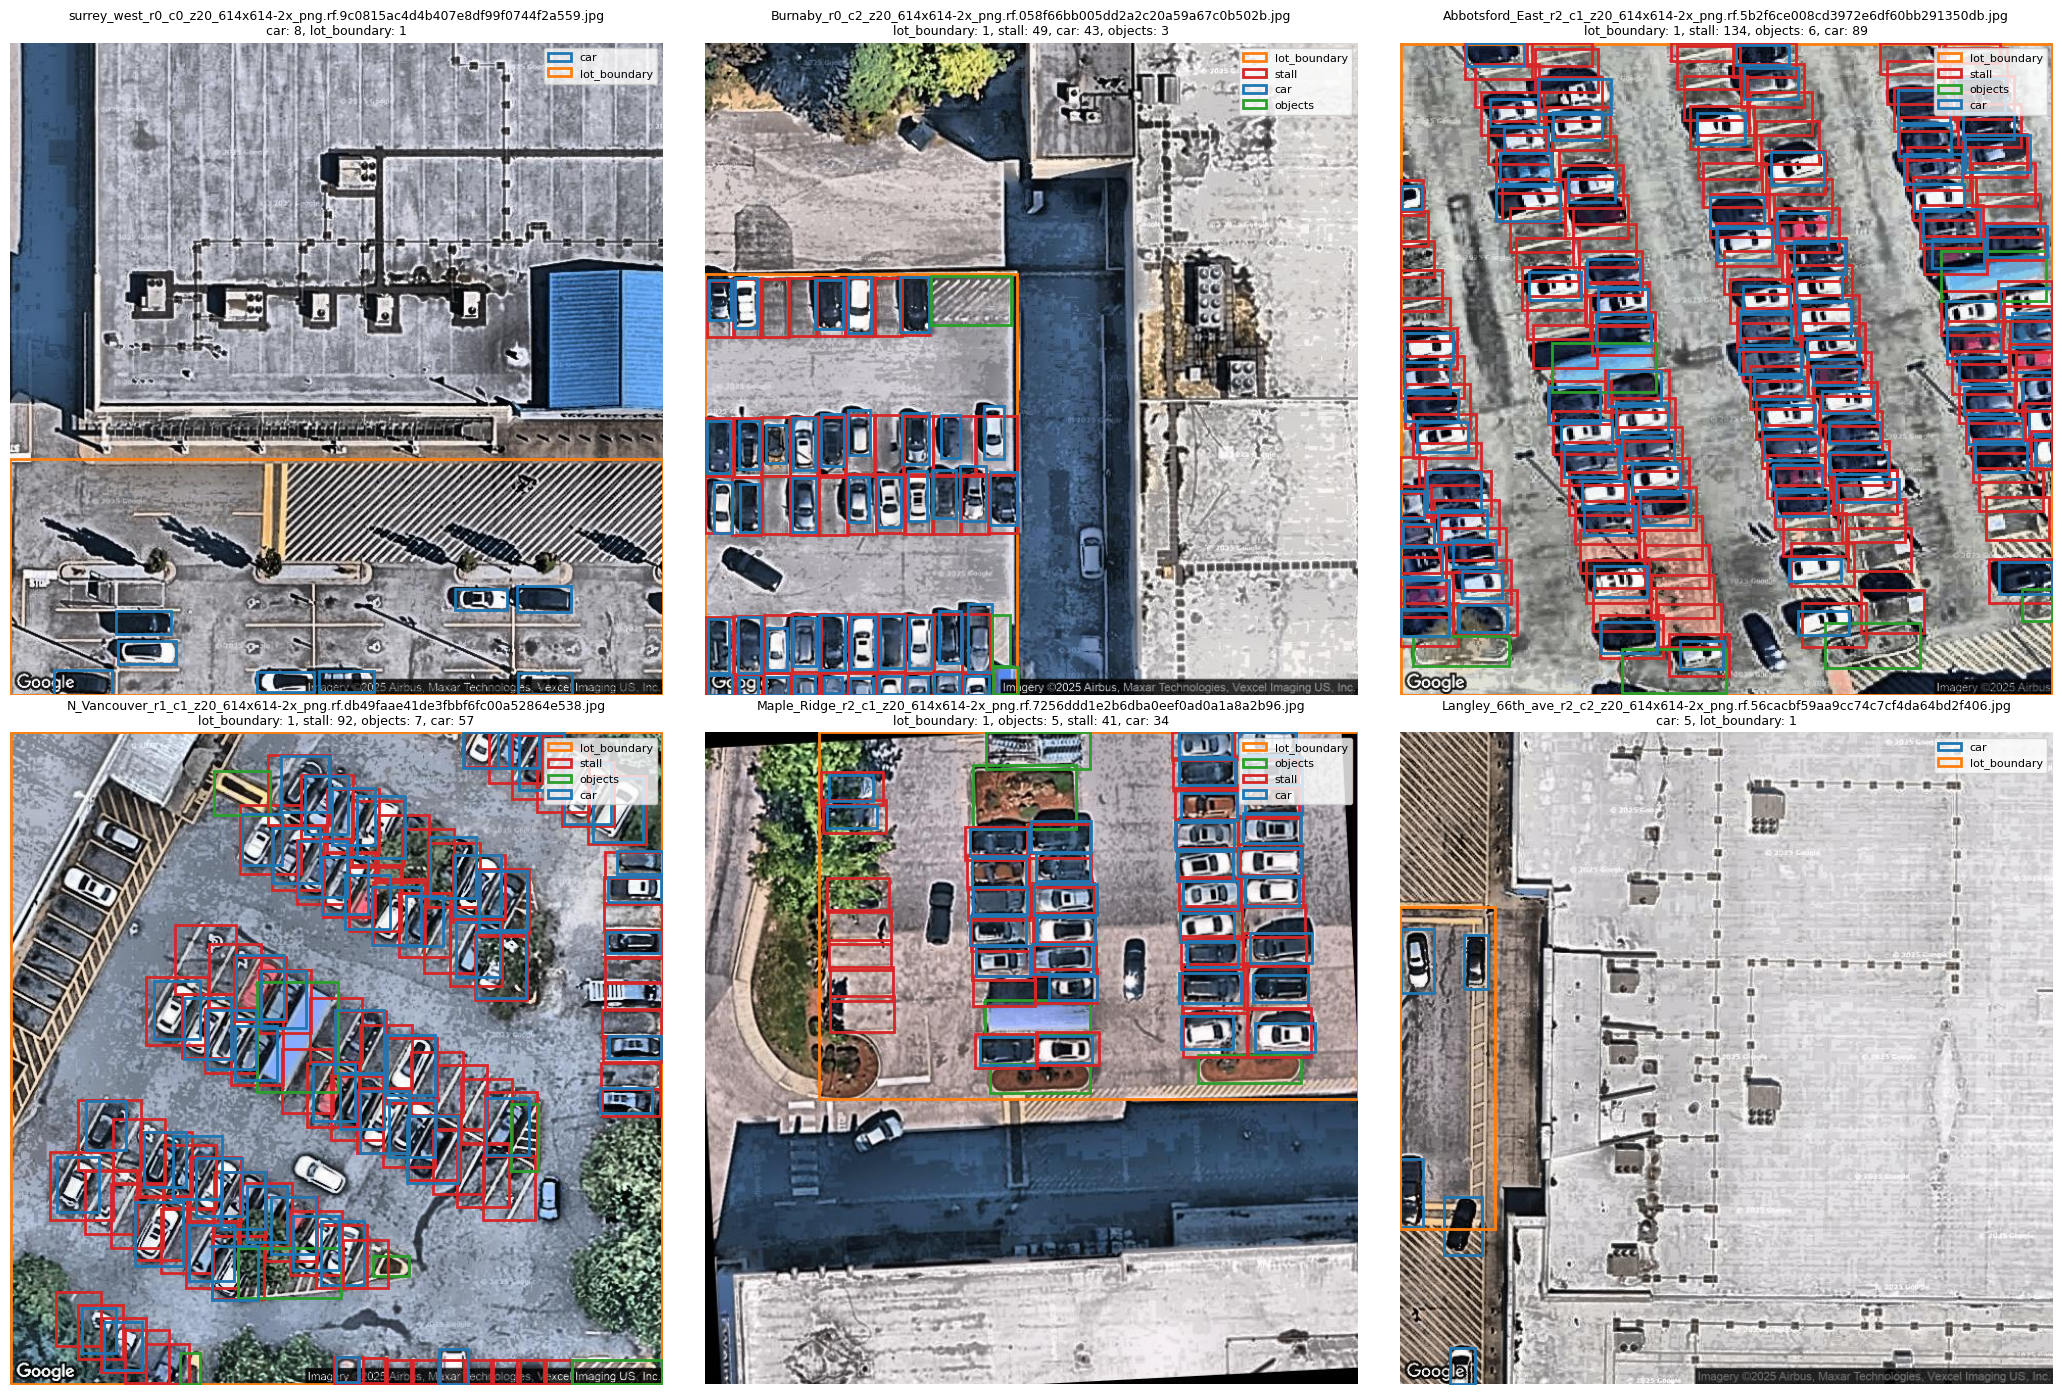


✅ Visualization complete!


In [10]:

from pathlib import Path as _PathViz
from matplotlib.patches import Rectangle
from PIL import Image
import random

def visualize_annotations(dataset_path, split='train', num_samples=6, target_classes=None, sample_index=None, seed=42):
    """
    Visualize YOLO bounding box annotations using matplotlib patches.
    Uses the same approach as visualize.ipynb for consistency.
    
    Args:
        dataset_path: Path to dataset root
        split: 'train', 'valid', or 'test'
        num_samples: Number of random samples to show
        target_classes: Tuple of class names to filter (None = show all)
        sample_index: Specific index to show (None = random)
        seed: Random seed for reproducibility
    """
    dataset_path = _PathViz(dataset_path)
    images_dir = dataset_path / split / 'images'
    labels_dir = dataset_path / split / 'labels'
    
    if not images_dir.exists():
        raise FileNotFoundError(f"Images directory not found: {images_dir}")

    # Load class names from data.yaml
    data_yaml_path = dataset_path / 'data.yaml'
    with open(data_yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
    class_names = data_config.get('names', [])
    
    # Color map for classes
    color_map = plt.get_cmap('tab10')
    class_colors = {i: color_map(i % 10) for i in range(len(class_names))}
    
    # Get image files
    image_files = sorted([f for f in images_dir.iterdir() if f.suffix.lower() in {'.jpg', '.png', '.jpeg'}])
    
    if not image_files:
        print(f"❌ No images found in {images_dir}")
        return
    
    # Select samples
    if sample_index is not None:
        selected = [image_files[sample_index]]
    else:
        rng = random.Random(seed)
        selected = rng.sample(image_files, min(num_samples, len(image_files)))
    
    # Create figure
    rows = (len(selected) + 2) // 3
    cols = min(3, len(selected))
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 7 * rows))
    
    if len(selected) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    print(f"\n🎨 Visualizing {len(selected)} samples from {split} set")
    print(f"📂 Dataset: {dataset_path.name}\n")
    
    for idx, img_path in enumerate(selected):
        # Load image using PIL (same as visualize.ipynb)
        image = Image.open(img_path).convert('RGB')
        width, height = image.size
        
        # Load labels
        label_path = labels_dir / (img_path.stem + '.txt')
        
        # Display image
        axes[idx].imshow(image)
        axes[idx].set_xlim(0, width)
        axes[idx].set_ylim(height, 0)
        
        class_counts = {}
        legend_handles = {}
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 5:
                        continue
                    
                    class_id = int(parts[0])
                    x_center, y_center, box_width, box_height = map(float, parts[1:5])
                    
                    if class_id >= len(class_names):
                        continue
                    
                    class_name = class_names[class_id]
                    
                    # Filter by target classes if specified
                    if target_classes and class_name not in target_classes:
                        continue
                    
                    # Convert YOLO format to pixel coordinates
                    x_min = (x_center - box_width / 2) * width
                    y_min = (y_center - box_height / 2) * height
                    w_px = box_width * width
                    h_px = box_height * height
                    
                    # Draw bounding box using matplotlib patches (clean rendering)
                    color = class_colors[class_id]
                    rect = Rectangle((x_min, y_min), w_px, h_px, 
                                   linewidth=2, edgecolor=color, facecolor='none')
                    axes[idx].add_patch(rect)
                    
                    # Track for legend
                    class_counts[class_name] = class_counts.get(class_name, 0) + 1
                    if class_name not in legend_handles:
                        legend_handles[class_name] = rect
        
        # Set title
        if class_counts:
            counts_str = ', '.join([f"{name}: {count}" for name, count in class_counts.items()])
            title = f"{img_path.name}\n{counts_str}"
        else:
            title = f"{img_path.name}\n(no annotations)"
        
        axes[idx].set_title(title, fontsize=9)
        axes[idx].axis('off')
        
        # Add legend
        if legend_handles:
            axes[idx].legend(legend_handles.values(), legend_handles.keys(), 
                           loc='upper right', fontsize=8, framealpha=0.8)
        
        print(f"Sample {idx + 1}: {img_path.name}")
        if class_counts:
            for name, count in class_counts.items():
                print(f"  ✓ {name}: {count}")
        else:
            print(f"  - No annotations")
    
    # Hide unused subplots
    for idx in range(len(selected), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Visualization complete!")

# Visualize ALL classes to verify Dataset-V1-detect conversion
print("=" * 70)
print("Showing ALL classes to verify Dataset-V1-detect has proper bboxes")
print("=" * 70)
visualize_annotations(dataset_path, 'train', num_samples=6, target_classes=None, seed=42)


## 4. Training Configuration


In [13]:

config = {
    'model': 'yolo11m.pt',
    'data': str(data_yaml),
    'epochs': 100,
    'batch': 16,
    'imgsz': 640,
    'patience': 20,
    'device': '0' if torch.cuda.is_available() else 'cpu',
    'project': 'parking_runs',
    'name': 'yolo11m_parking',
    'workers': 8,
    'classes': [0],  # train only on the car class
    
    # Data Augmentation Parameters
    'hsv_h': 0.015,      # HSV-Hue augmentation (fraction)
    'hsv_s': 0.7,        # HSV-Saturation augmentation (fraction)
    'hsv_v': 0.4,        # HSV-Value augmentation (fraction)
    'degrees': 10.0,     # Rotation (+/- deg)
    'translate': 0.1,    # Translation (+/- fraction)
    'scale': 0.5,        # Scaling (+/- gain)
    'shear': 0.0,        # Shear (+/- deg)
    'perspective': 0.0,  # Perspective (+/- fraction), range 0-0.001
    'flipud': 0.0,       # Vertical flip (probability)
    'fliplr': 0.5,       # Horizontal flip (probability)
    'mosaic': 1.0,       # Mosaic augmentation (probability)
    'mixup': 0.0,        # MixUp augmentation (probability)
    'copy_paste': 0.0,   # Copy-paste augmentation (probability)
}

print("🔧 Training Configuration")
print('=' * 60)
print(f"Dataset path: {dataset_path}")
print("\n📊 Training Parameters:")
for key, value in config.items():
    if key in ['model', 'data', 'epochs', 'batch', 'imgsz', 'patience', 'device', 'project', 'name', 'workers', 'classes']:
        print(f"  {key}: {value}")

print("\n🎨 Data Augmentation:")
for key, value in config.items():
    if key in ['hsv_h', 'hsv_s', 'hsv_v', 'degrees', 'translate', 'scale', 'shear', 'perspective', 'flipud', 'fliplr', 'mosaic', 'mixup', 'copy_paste']:
        print(f"  {key}: {value}")


🔧 Training Configuration
Dataset path: /Users/ay/Desktop/deeplearning/Parking lot /Parking-Lot-Occupancy-Estimation-/Dataset-V1-detect

📊 Training Parameters:
  model: yolo11m.pt
  data: /Users/ay/Desktop/deeplearning/Parking lot /Parking-Lot-Occupancy-Estimation-/Dataset-V1-detect/data.yaml
  epochs: 100
  batch: 16
  imgsz: 640
  patience: 20
  device: cpu
  project: parking_runs
  name: yolo11m_parking
  workers: 8
  classes: [0]

🎨 Data Augmentation:
  hsv_h: 0.015
  hsv_s: 0.7
  hsv_v: 0.4
  degrees: 10.0
  translate: 0.1
  scale: 0.5
  shear: 0.0
  perspective: 0.0
  flipud: 0.0
  fliplr: 0.5
  mosaic: 1.0
  mixup: 0.0
  copy_paste: 0.0


## 5. Train Model


In [ ]:

model = YOLO(config['model'])
results = model.train(
    data=config['data'],
    epochs=config['epochs'],
    batch=config['batch'],
    imgsz=config['imgsz'],
    patience=config['patience'],
    device=config['device'],
    project=config['project'],
    name=config['name'],
    workers=config['workers'],
    classes=config['classes']
)
print("✅ Training completed!")


New https://pypi.org/project/ultralytics/8.3.229 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.225 🚀 Python-3.12.10 torch-2.9.0 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=[0], close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/ay/Desktop/deeplearning/Parking lot /Parking-Lot-Occupancy-Estimation-/Dataset-V1-detect/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0,

## 6. View Results


In [ ]:

results_dir = os.path.join(config['project'], config['name'])
plot_files = ['results.png', 'confusion_matrix.png', 'F1_curve.png',
              'PR_curve.png', 'P_curve.png', 'R_curve.png']

available_plots = [p for p in plot_files if os.path.exists(os.path.join(results_dir, p))]

if available_plots:
    rows = (len(available_plots) + 2) // 3
    cols = min(3, len(available_plots))
    fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 6 * rows))
    if isinstance(axes, plt.Axes):
        axes = [axes]
    else:
        axes = axes.flatten()

    for idx, plot_name in enumerate(available_plots):
        img = plt.imread(os.path.join(results_dir, plot_name))
        axes[idx].imshow(img)
        axes[idx].set_title(plot_name.replace('.png', '').replace('_', ' ').title())
        axes[idx].axis('off')

    for idx in range(len(available_plots), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

best_path = os.path.join(results_dir, 'weights', 'best.pt')
if os.path.exists(best_path):
    print(f"✅ Best model: {best_path}")
else:
    print('Best weights not found yet.')


## 7. Test Predictions


In [ ]:

best_path = os.path.join(config['project'], config['name'], 'weights', 'best.pt')

if os.path.exists(best_path):
    model = YOLO(best_path)
    test_images_dir = dataset_path / 'test' / 'images'
    test_images = [str(p) for p in sorted(test_images_dir.iterdir()) if p.suffix.lower() in {'.jpg', '.png', '.jpeg'}][:6]

    if test_images:
        results = model.predict(test_images, conf=0.25, iou=0.45, save=False, verbose=False)

        rows = (len(test_images) + 2) // 3
        cols = min(3, len(test_images))
        fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 6 * rows))
        if isinstance(axes, plt.Axes):
            axes = [axes]
        else:
            axes = axes.flatten()

        for idx, result in enumerate(results):
            img = cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB)
            axes[idx].imshow(img)
            axes[idx].set_title(f"Test {idx + 1}: {len(result.boxes)} detections")
            axes[idx].axis('off')

        for idx in range(len(test_images), len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print('No test images found to visualize predictions.')
else:
    print('Best model weights not found. Run training first or check the results directory.')
